# Experiments using encoded data as input to the Gate

## With MNIST dataset

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.cm as cm  # colormaps

%matplotlib inline

In [2]:
import seaborn as sns
import numpy as np
from statistics import mean
from math import ceil, sin, cos, radians
from collections import OrderedDict
import os
import pandas as pd
from pprint import pprint
from copy import deepcopy

In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('device', device)
else:
    device = torch.device("cpu")
    print('device', device)

device cuda:0


In [5]:
# import MoE expectation model. All experiments for this dataset are done with the expectation model as it
# provides the best guarantee of interpretable task decompositions
from moe_models.moe_expectation_model import moe_expectation_model
from helper.moe_models import cross_entropy_loss

device cuda:0
device cuda:0


### NOTE: Pre-trained models are provided to check the results of all the experiments if you do not have the time to train all the models. 

## Load MNIST dataset

In [6]:
# Paths to where the trained models and figures will be stored. You can change this as you see fit.
fig_path = '../figures/test'
model_path = '../models/test'
pre_trained_model_path = '../models/pre_trained'

if not os.path.exists(fig_path):
    os.mkdir(fig_path)
if not os.path.exists(model_path):
    os.mkdir(model_path)

In [19]:
# Load and split data as train and test
batch_size = 512

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root="data", train=True, transform=transform, download=True)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.MNIST(root="data", train=False, transform=transform, download=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=True)

num_classes = 10

image, label = trainset.__getitem__(0)
print('Image shape', image.shape)
print('Train samples ', len(trainset))
print('Test samples ', len(testset))

Image shape torch.Size([1, 28, 28])
Train samples  60000
Test samples  10000


In [20]:
def load_data(path):
    with np.load(path) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']
        return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_data('data/mnist.npz')

In [21]:
x_train.shape

(60000, 28, 28)

In [ ]:
def rotate_dataset(d, rotation):
    result = torch.FloatTensor(d.size(0), 784)
    tensor = transforms.ToTensor()

    for i in range(d.size(0)):
        img = Image.fromarray(d[i].numpy(), mode='L')
        result[i] = tensor(img.rotate(rotation)).view(784)
    return result

In [22]:
# helper function to show an image
# (used in the `plot_classes_preds` function below)
def imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [23]:
torch.tensor(x_train[0:32]).shape

torch.Size([32, 28, 28])

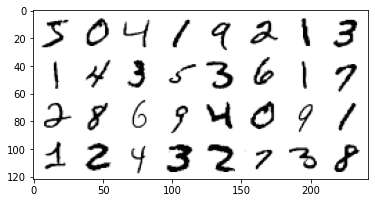

In [25]:
img_grid = torchvision.utils.make_grid(torch.tensor(x_train[0:32]).type(torch.float).view(-1,1,28,28))
imshow(img_grid, one_channel=True)

torch.Size([512, 1, 28, 28])
Data samples


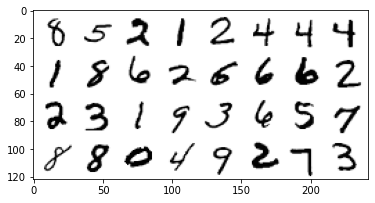

In [24]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)
# create grid of images
img_grid = torchvision.utils.make_grid(images[0:32])

print('Data samples')
# show images
imshow(img_grid, one_channel=True)


## Define expert and gate networks

In [10]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class expert_layers(nn.Module):
    def __init__(self, num_classes, output):
        super(expert_layers, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5)
        self.fc1 = nn.Linear(in_features=1*12*12, out_features=5) # this is a pure linear transform
        self.fc2 = nn.Linear(in_features=5, out_features=10) # this is a pure linear transform
        
        self.out = nn.Linear(in_features=10, out_features=num_classes)
        
        self.num_classes = num_classes
        self.output = output
        
    def forward(self, t):
        # conv 1
        t = self.conv1(t)
        
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # fc1
        t = t.reshape(-1, 1*12*12)
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = F.softmax(self.out(t), dim=1)
                
        return t

In [11]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class gate_layers(nn.Module):
    def __init__(self, num_experts, num_classes):
        super(gate_layers, self).__init__()
        # define layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5)

        self.fc1 = nn.Linear(in_features=1*12*12, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.out = nn.Linear(in_features=64, out_features=num_experts)
        self.num_experts = num_experts
        self.num_classes = num_classes
        self.count = 0

    def forward(self, t, T=1.0, y=None):
        # conv 1
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)
        # fc1
        t = t.reshape(-1, 1*12*12)
        if not y is None:
            t = torch.cat((t, torch.flatten(y, start_dim=1)), dim=1)
            self.fc1 = nn.Linear(in_features=1*12*12+(self.num_experts* self.num_classes), out_features=15)
            
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = self.out(t)
        t = F.softmax(t/T, dim=1)
        return t


In [12]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class gate_layers_with_encoder(nn.Module):
    def __init__(self, num_experts, encoder=None):
        super(gate_layers_with_encoder, self).__init__()

        # use encoder to first encode the input
        self.encoder = encoder

        # define layers

        self.fc1 = nn.Linear(in_features=128, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.out = nn.Linear(in_features=64, out_features=num_experts)

    def forward(self, t, T=1.0, y=None):
        # conv 1

        t = self.encoder(t)
        
        # fc1
        t = self.fc1(t)
        t = F.relu(t)
        
        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = self.out(t)
        t = F.softmax(t/T, dim=1)
        return t


In [13]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class gate_encoder(nn.Module):
    def __init__(self, num_experts):
        super(gate_encoder, self).__init__()

        # define layers
        self.encoder_hidden_layer = nn.Linear(in_features=1*28*28, out_features=128)
        self.encoder_output_layer = nn.Linear(in_features=128, out_features=128)

    def forward(self, t, T=1.0):
        t = t.view(-1, 784)
        activation = self.encoder_hidden_layer(t)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.sigmoid(code)
        return code

In [14]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class gate_decoder(nn.Module):
    def __init__(self, num_experts):
        super(gate_decoder, self).__init__()
        
        self.decoder_hidden_layer = nn.Linear(in_features=128, out_features=128)
        self.decoder_output_layer = nn.Linear(in_features=128, out_features=1*28*28)
        
    def forward(self, t, T=1.0):        
        activation = self.decoder_hidden_layer(t)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.sigmoid(activation)
        return reconstructed


In [15]:
# create a set of experts
def experts(num_experts, total_num_classes, num_classes, expert_layers_type=expert_layers):
    models = []
    for i in range(num_experts):
        models.append(expert_layers_type(total_num_classes, num_classes[i]))
    return nn.ModuleList(models)

## Initialize configurations and helper functions

In [16]:
def accuracy(out, yb, mean=True):
    preds = torch.argmax(out, dim=1).to(device, non_blocking=True)
    if mean:
        return (preds == yb).float().mean()
    else:
        return (preds == yb).float()

In [17]:
# gate covariant shift regularization flag 
w_importance=0.0 

def generate_plot_file(dataset, specific):
    plot_file = dataset
    if w_importance > 0:
        plot_file += '_importance_'+str(w_importance)
    plot_file += '_'+specific
    
    return plot_file

In [18]:
def train_encoder_decoder(encoder, decoder, num_experts, num_epochs=20):

    loss_criterion = nn.MSELoss()
        
    params = list(encoder.parameters())+list(decoder.parameters())
    optimizer = optim.Adam(params, lr=1e-3)
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                    
            e_outputs = encoder(inputs)
            
            outputs = decoder(e_outputs)
            
            optimizer.zero_grad()
            
            # convert image 1x28x28 to 784 (28x28)
            inputs = inputs.view(-1, 784)
            loss = loss_criterion(outputs, inputs)

            loss.backward()

            optimizer.step()

            running_loss += loss.item()

        print('Encoder Training: epoch %d' % epoch,
              'training loss %.2f' % (running_loss/len(trainloader)))
    return encoder, decoder

In [19]:
# Train the MoE model 

def train_model(gate_model, model_name, w_importance=0.0):
    models = {
        'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss,'experts':{}},
        }

    for key, val in models.items():
        print('Model:', key, total_experts, 'Experts')
        expert_models = experts(total_experts, num_classes, 
                                [num_classes]*total_experts).to(device)

        moe_model = val['model'](total_experts, num_classes, augment=0, attention_flag=0,
                                 experts=expert_models, gate=gate_model)

        params = [p.numel() for p in moe_model.parameters() if p.requires_grad]
        print('model params:', sum(params))

        optimizer_moe = optim.Adam(moe_model.parameters(),
                                  lr=1e-3)
        hist = moe_model.train(trainloader, testloader,  val['loss'], optimizer_moe, 
                               w_importance=w_importance, accuracy=accuracy, epochs=num_epochs)
        val['experts'][total_experts] = {'model':moe_model, 'history':hist}

    plot_file = generate_plot_file(model_name, str(num_classes)+'_'+str(total_experts)+'_models.pt')
    torch.save(models, open(os.path.join(model_path, plot_file),'wb'))

In [20]:
total_experts = 5

In [21]:
num_epochs = 20

In [22]:
# First train the encoder/decoder

encoder = gate_encoder(total_experts).to(device)
decoder = gate_decoder(total_experts).to(device)

encoder, decoder = train_encoder_decoder(encoder, decoder, total_experts, num_epochs)

plot_file = generate_plot_file('simple_encoder_decoder', str(num_classes)+'_'+str(total_experts)+'_models.pt')
torch.save([encoder, decoder], open(os.path.join(model_path, plot_file),'wb'))

Encoder Training: epoch 0 training loss 0.08
Encoder Training: epoch 1 training loss 0.06
Encoder Training: epoch 2 training loss 0.06
Encoder Training: epoch 3 training loss 0.05
Encoder Training: epoch 4 training loss 0.05
Encoder Training: epoch 5 training loss 0.04
Encoder Training: epoch 6 training loss 0.04
Encoder Training: epoch 7 training loss 0.04
Encoder Training: epoch 8 training loss 0.04
Encoder Training: epoch 9 training loss 0.03
Encoder Training: epoch 10 training loss 0.03
Encoder Training: epoch 11 training loss 0.03
Encoder Training: epoch 12 training loss 0.03
Encoder Training: epoch 13 training loss 0.03
Encoder Training: epoch 14 training loss 0.03
Encoder Training: epoch 15 training loss 0.02
Encoder Training: epoch 16 training loss 0.02
Encoder Training: epoch 17 training loss 0.02
Encoder Training: epoch 18 training loss 0.02
Encoder Training: epoch 19 training loss 0.02


In [23]:
# Load the pre-trained encoder/decoder

plot_file = generate_plot_file('simple_encoder_decoder', str(num_classes)+'_'+str(total_experts)+'_models.pt')
encoder, decoder = torch.load(open(os.path.join(model_path, plot_file),'rb'))

In [24]:
# Freeze the parameters of the encoder so it is not trained.
for param in encoder.parameters():
    param.requires_grad = False

In [25]:
# Build the MoE model where the gate model input is the encoded input.
model_1 = 'mnist_gate_with_encoder'
gate_model = gate_layers_with_encoder(total_experts, encoder)
train_model(gate_model, model_1)

Model: moe_expectation_model 5 Experts
model params: 29698
epoch 0 training loss 1.71 , training accuracy 0.45 , test accuracy 0.80
epoch 1 training loss 0.58 , training accuracy 0.83 , test accuracy 0.86
epoch 2 training loss 0.46 , training accuracy 0.86 , test accuracy 0.87
epoch 3 training loss 0.41 , training accuracy 0.88 , test accuracy 0.89
epoch 4 training loss 0.37 , training accuracy 0.89 , test accuracy 0.90
epoch 5 training loss 0.34 , training accuracy 0.90 , test accuracy 0.90
epoch 6 training loss 0.31 , training accuracy 0.90 , test accuracy 0.91
epoch 7 training loss 0.29 , training accuracy 0.91 , test accuracy 0.92
epoch 8 training loss 0.27 , training accuracy 0.92 , test accuracy 0.92
epoch 9 training loss 0.25 , training accuracy 0.92 , test accuracy 0.92
epoch 10 training loss 0.24 , training accuracy 0.93 , test accuracy 0.93
epoch 11 training loss 0.23 , training accuracy 0.93 , test accuracy 0.93
epoch 12 training loss 0.23 , training accuracy 0.93 , test acc

In [26]:
# Build the MoE model where the gate model input is the encoded input.
model_2 = 'mnist_with_regularization'

gate_model_2 = gate_layers(total_experts, num_classes)
w_importance=1.0 
train_model(gate_model_2, model_2, w_importance=1.0 )
w_importance=0.0 

Model: moe_expectation_model 5 Experts
model params: 31772
epoch 0 training loss 1.77 , training accuracy 0.47 , test accuracy 0.80
epoch 1 training loss 0.60 , training accuracy 0.84 , test accuracy 0.88
epoch 2 training loss 0.43 , training accuracy 0.88 , test accuracy 0.90
epoch 3 training loss 0.33 , training accuracy 0.91 , test accuracy 0.92
epoch 4 training loss 0.28 , training accuracy 0.92 , test accuracy 0.93
epoch 5 training loss 0.25 , training accuracy 0.93 , test accuracy 0.93
epoch 6 training loss 0.22 , training accuracy 0.94 , test accuracy 0.94
epoch 7 training loss 0.20 , training accuracy 0.94 , test accuracy 0.94
epoch 8 training loss 0.19 , training accuracy 0.95 , test accuracy 0.95
epoch 9 training loss 0.17 , training accuracy 0.95 , test accuracy 0.95
epoch 10 training loss 0.16 , training accuracy 0.96 , test accuracy 0.95
epoch 11 training loss 0.16 , training accuracy 0.96 , test accuracy 0.95
epoch 12 training loss 0.15 , training accuracy 0.96 , test acc

In [27]:
# Build the MoE model where the gate model input is the encoded input.
model_3 = 'mnist_without_regularization'

gate_model_3 = gate_layers(total_experts, num_classes)
train_model(gate_model_3, model_3)

Model: moe_expectation_model 5 Experts
model params: 31772
epoch 0 training loss 1.72 , training accuracy 0.46 , test accuracy 0.72
epoch 1 training loss 0.60 , training accuracy 0.80 , test accuracy 0.84
epoch 2 training loss 0.41 , training accuracy 0.86 , test accuracy 0.89
epoch 3 training loss 0.33 , training accuracy 0.90 , test accuracy 0.91
epoch 4 training loss 0.28 , training accuracy 0.91 , test accuracy 0.92
epoch 5 training loss 0.25 , training accuracy 0.92 , test accuracy 0.93
epoch 6 training loss 0.23 , training accuracy 0.93 , test accuracy 0.93
epoch 7 training loss 0.21 , training accuracy 0.94 , test accuracy 0.94
epoch 8 training loss 0.19 , training accuracy 0.94 , test accuracy 0.94
epoch 9 training loss 0.18 , training accuracy 0.95 , test accuracy 0.95
epoch 10 training loss 0.17 , training accuracy 0.95 , test accuracy 0.95
epoch 11 training loss 0.16 , training accuracy 0.95 , test accuracy 0.94
epoch 12 training loss 0.16 , training accuracy 0.95 , test acc

Original input


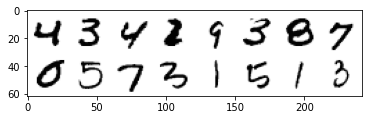

Decoder output


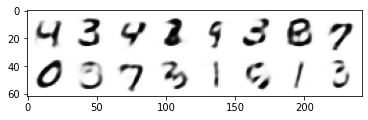

TSNE projection of the original input


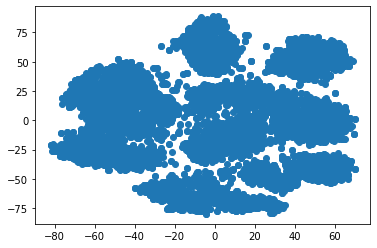

TSNE projection of the decoder output


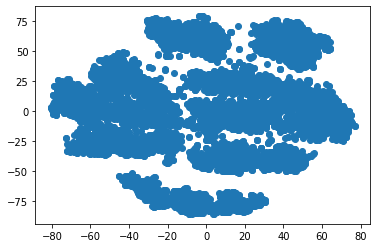

In [52]:
from sklearn.manifold import TSNE
for inputs, labels in testloader:
    inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

    e_outputs = encoder(inputs)
   
    d_outputs = decoder(e_outputs).cpu().detach()
    
    print('Original input')
    img_grid = torchvision.utils.make_grid(inputs[0:16].cpu().detach())
    imshow(img_grid, one_channel=True)
    
    print('Decoder output')
    img_grid = torchvision.utils.make_grid(d_outputs.reshape(-1,1,28,28)[0:16])
    imshow(img_grid, one_channel=True)   
    
    print('TSNE projection of the original input')
    img_embedded = TSNE().fit_transform(inputs.cpu().detach().reshape((-1, 1*28*28)))
    plt.scatter(img_embedded[:,0], img_embedded[:,1])
    plt.show()
        
    print('TSNE projection of the encoder output')
    img_embedded = TSNE().fit_transform(e_outputs.cpu().detach().numpy())
    plt.scatter(img_embedded[:,0], img_embedded[:,1])
    
    
    break

Model: mnist_gate_with_encoder_10_5_models.pt
Model: mnist_with_regularization_importance_1.0_10_5_models.pt
Model: mnist_without_regularization_10_5_models.pt

Experts used by the gate for classification of each digit

Experts used by the gate for classification of each digit

Experts used by the gate for classification of each digit


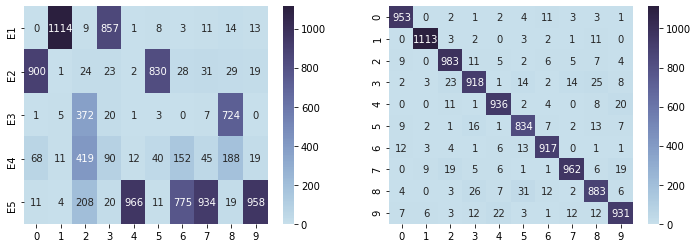

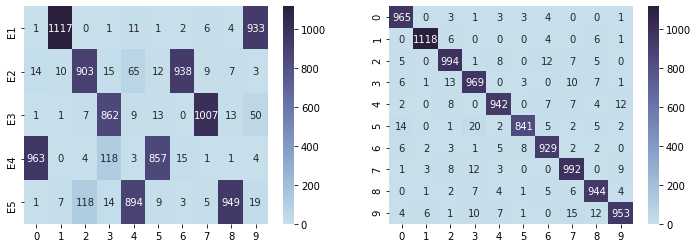

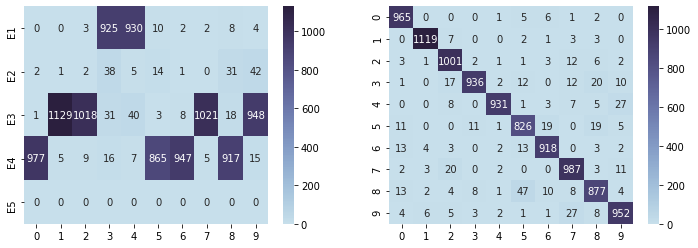

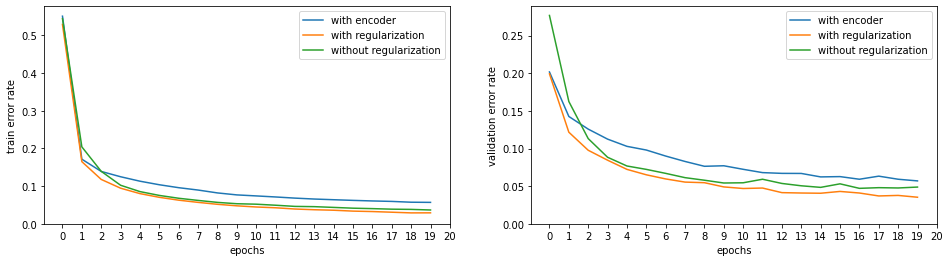

In [30]:
from sklearn.metrics import confusion_matrix

total_experts = 5

m = 'mnist_gate_with_encoder'


plot_file = generate_plot_file(m, str(num_classes)+'_'+str(total_experts)+'_models.pt')

# Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
# model you build above
model_1 = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)
print('Model:', plot_file)

m = 'mnist_with_regularization'

w_importance = 1.0

plot_file = generate_plot_file(m, str(num_classes)+'_'+str(total_experts)+'_models.pt')

w_importance = 0.0

# Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
# model you build above
model_2 = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)
print('Model:', plot_file)

m = 'mnist_without_regularization'

plot_file = generate_plot_file(m, str(num_classes)+'_'+str(total_experts)+'_models.pt')

# Note: Here we are loading the pre-trained model from 'pre_trained_model_path. Change this to 'model_path' to load the 
# model you build above
model_3 = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)
print('Model:', plot_file)

fig1,ax1 = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(12, 4))
ax1.flatten()

# Plotting for the model with encoder
for e_key, e_val in model_1.items():
    cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        moe_model = e_val['experts'][total_experts]['model']
        
        # predict the classes for test data
        pred = moe_model(images)
        pred_labels = torch.argmax(pred, dim=1)

        expert_outputs = moe_model.expert_outputs
        gate_outputs = moe_model.gate_outputs

        # get the experts selected by the gate for each sample
        pred_gate_labels = torch.argmax(gate_outputs, dim=1)

        # plot the expert selection table
        print('\nExperts used by the gate for classification of each digit')
        class_expert_table = np.asarray([[0] * num_classes]*total_experts)
        for label, expert in zip(labels, pred_gate_labels):
            class_expert_table[expert,label] += 1
        sns.heatmap(class_expert_table, yticklabels=['E'+str(i) for i in range(1,total_experts+1)], 
                    annot=True, cmap=cmap, fmt='d', ax=ax1[0])
        
        sns.heatmap(confusion_matrix(labels.cpu(), pred_labels.cpu()), annot=True, ax=ax1[1], cmap=cmap, fmt='d')
    
fig2,ax2 = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(12, 4))
ax2.flatten()

# Plotting for the model with reg
for e_key, e_val in model_2.items():
    cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        moe_model = e_val['experts'][total_experts]['model']
        
        # predict the classes for test data
        pred = moe_model(images)
        pred_labels = torch.argmax(pred, dim=1)

        expert_outputs = moe_model.expert_outputs
        gate_outputs = moe_model.gate_outputs

        # get the experts selected by the gate for each sample
        pred_gate_labels = torch.argmax(gate_outputs, dim=1)

        # plot the expert selection table
        print('\nExperts used by the gate for classification of each digit')
        class_expert_table = np.asarray([[0] * num_classes]*total_experts)
        for label, expert in zip(labels, pred_gate_labels):
            class_expert_table[expert,label] += 1
        sns.heatmap(class_expert_table, yticklabels=['E'+str(i) for i in range(1,total_experts+1)], 
                    annot=True, cmap=cmap, fmt='d', ax=ax2[0])
        
        sns.heatmap(confusion_matrix(labels.cpu(), pred_labels.cpu()), annot=True, ax=ax2[1], cmap=cmap, fmt='d')

fig3,ax3 = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(12, 4))
ax3.flatten()

# Plotting for the model without reg
for e_key, e_val in model_3.items():
    cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True)

    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        moe_model = e_val['experts'][total_experts]['model']
        
        # predict the classes for test data
        pred = moe_model(images)
        pred_labels = torch.argmax(pred, dim=1)

        expert_outputs = moe_model.expert_outputs
        gate_outputs = moe_model.gate_outputs

        # get the experts selected by the gate for each sample
        pred_gate_labels = torch.argmax(gate_outputs, dim=1)

        # plot the expert selection table
        print('\nExperts used by the gate for classification of each digit')
        class_expert_table = np.asarray([[0] * num_classes]*total_experts)
        for label, expert in zip(labels, pred_gate_labels):
            class_expert_table[expert,label] += 1
        sns.heatmap(class_expert_table, yticklabels=['E'+str(i) for i in range(1,total_experts+1)], 
                    annot=True, cmap=cmap, fmt='d', ax=ax3[0])
        
        sns.heatmap(confusion_matrix(labels.cpu(), pred_labels.cpu()), annot=True, ax=ax3[1], cmap=cmap, fmt='d')


for e_key, e_val in model_1.items():
    
    fig4,ax4 = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(16,4))
    ax4 = ax4.flatten()
    sns.lineplot(x=range(num_epochs), y=1-np.asarray(model_1[e_key]['experts'][total_experts]['history']['accuracy']), ax=ax4[0])
    sns.lineplot(x=range(num_epochs), y=1-np.asarray(model_2[e_key]['experts'][total_experts]['history']['accuracy']), ax=ax4[0])
    sns.lineplot(x=range(num_epochs), y=1-np.asarray(model_3[e_key]['experts'][total_experts]['history']['accuracy']), ax=ax4[0])

    ax4[0].legend(['with encoder', 
                   'with regularization',
                   'without regularization'])
    
    ax4[0].set_xlabel('epochs')
    ax4[0].set_xticks(range(num_epochs+1))
    ax4[0].set_ylabel('train error rate')
    ax4[0].set_ylim(ymin=0)

    sns.lineplot(x=range(num_epochs), y=1-np.asarray(model_1[e_key]['experts'][total_experts]['history']['val_accuracy']), ax=ax4[1])
    sns.lineplot(x=range(num_epochs), y=1-np.asarray(model_2[e_key]['experts'][total_experts]['history']['val_accuracy']), ax=ax4[1])
    sns.lineplot(x=range(num_epochs), y=1-np.asarray(model_3[e_key]['experts'][total_experts]['history']['val_accuracy']), ax=ax4[1])

    ax4[1].legend(['with encoder', 
                   'with regularization',
                   'without regularization'])
    
    ax4[1].set_xlabel('epochs')
    ax4[1].set_xticks(range(num_epochs+1))
    ax4[1].set_ylabel('validation error rate')
    ax4[1].set_ylim(ymin=0)
    
    plt.show()

        
# image_file = generate_plot_file('compare_encoder', 'class_expert_table_reg_'+str(num_classes)+'_'+str(total_experts)+'_experts.png')
# fig1.savefig(os.path.join(fig_path, image_file))
plt.show()
